In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

In [2]:
# dataframe의 모든 행을 0~1 사이로 scaling
def scale_df(df):
    return (df-df.min())/(df.max()-df.min())

In [3]:
# dataframe 만들고 중요 데이터에 대한 dataframe 따로 만든다
df = pd.read_csv('KOSPI.csv')
data_imp = df[['prices', 'volume_p', 'volume_i', 'volume_f']].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3919 entries, 0 to 3918
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  3919 non-null   int64  
 1   dates       3919 non-null   int64  
 2   prices      3919 non-null   float64
 3   volume_p    3919 non-null   int64  
 4   volume_i    3919 non-null   int64  
 5   volume_f    3919 non-null   int64  
dtypes: float64(1), int64(5)
memory usage: 183.8 KB


In [4]:
t = 20 # t일 간의 변동성, 지수 평균 사용
m = 5 # 앞 뒤 m일의 데이터 사용
n = 30 # 상위 n개의 데이터 사용
d = 60 # 기준 index 간 5의 차이 (날짜의 차이)

# 2020.03 / 3745, 3764 / 코로나
# 2011.08 / 1651 / 유럽 쇼크
# 2008.10 / 946 / 서브프라임
std = data_imp.rolling(t).std().dropna()

# 평균에 비해 2sigma or 3sigma 이상 차이 나는 경우
# 과거 20일간의 지수 평균과 다음 지수와 비교해야해서 과거 평균의 index를 1 증가시킴
df_mean = data_imp.rolling(t).mean().dropna()[:-1]
two_mean_plus = (df_mean + 2*std[:-1])
two_mean_minus = (df_mean - 2*std[:-1])
three_mean_plus = (df_mean + 3*std[:-1])
three_mean_minus = (df_mean - 3*std[:-1])
df_mean.index = [i for i in range(t,len(df))]
two_mean_plus.index = [i for i in range(t,len(df))]
two_mean_minus.index = [i for i in range(t,len(df))]
three_mean_plus.index = [i for i in range(t,len(df))]
three_mean_minus.index = [i for i in range(t,len(df))]

# 총 4개씩, 순서대로 prices, volume_p, volume_i, volume_f
two_rise_idx = []
two_fall_idx=[]
twosigma_rise=[]
twosigma_fall = []

three_rise_idx = []
three_fall_idx=[]
threesigma_rise=[]
threesigma_fall = []
for i,c in zip(range(len(data_imp.columns)), data_imp.columns):
    two_rise_idx.append(data_imp[c][t:][data_imp[c][t:]>two_mean_plus[c]].index)
    two_fall_idx.append(data_imp[c][t:][data_imp[c][t:]<two_mean_minus[c]].index)
    twosigma_rise.append((data_imp[c][two_rise_idx[i]]-df_mean[c][two_rise_idx[i]])/df_mean[c][two_rise_idx[i]])
    twosigma_fall.append((data_imp[c][two_fall_idx[i]]-df_mean[c][two_fall_idx[i]])/df_mean[c][two_fall_idx[i]])

    three_rise_idx.append(data_imp[c][t:][data_imp[c][t:]>three_mean_plus[c]].index)
    three_fall_idx.append(data_imp[c][t:][data_imp[c][t:]<three_mean_minus[c]].index)
    threesigma_rise.append((data_imp[c][three_rise_idx[i]]-df_mean[c][three_rise_idx[i]])/df_mean[c][three_rise_idx[i]])
    threesigma_fall.append((data_imp[c][three_fall_idx[i]]-df_mean[c][three_fall_idx[i]])/df_mean[c][three_fall_idx[i]])

In [5]:
# 차이가 큰 순서대로 정렬
std_idx = [std[i].sort_values(ascending=False).index.values for i in std.columns]
twosigma_rise_s = [twosigma_rise[i].sort_values(ascending=False).index.values for i in range(len(two_rise_idx))]
twosigma_fall_s = [twosigma_fall[i].sort_values(ascending=True).index.values for i in range(len(two_fall_idx))]
threesigma_rise_s = [threesigma_rise[i].sort_values(ascending=False).index.values for i in range(len(three_rise_idx))]
threesigma_fall_s = [threesigma_fall[i].sort_values(ascending=True).index.values for i in range(len(three_fall_idx))]

# index의 순서
    # std, twofall, tworise, threefall, threerise
    # price, vp, vi, vf
idx_list_n = []
idx_list_all = []

# 각 날짜는 적어도 d일의 차이를 갖는다
for l in [std_idx, twosigma_fall_s, twosigma_rise_s, threesigma_fall_s, threesigma_rise_s]:
    for sl in l:
        idx_n = 0  # 새로 만들 list의 index
        temp = np.ones(len(sl)) * -100  #한자리수 index를 고려해서 -100 곱함
        for i in sl:
            if not (set(temp[temp > i-d]) & set(temp[temp < i + d])):
                temp[idx_n] = i
                idx_n += 1
        idx_list_all.append(temp[:idx_n].astype(int))
        idx_list_n.append(temp[:n].astype(int))

In [6]:
# 구한 index로 prices, private, institution, foreigner 간의 상관관계를 구한다.
# 앞 뒤 m일 간의 데이터를 가져와서 total, before, after로 나눠서 상관관계를 구한다.

def get_corr(idx_list, two_three, m, n):
    corr_fall = [] # total before after
    corr_fall_n = []
    corr_rise = [] # total before after
    corr_rise_n = []
    if two_three == 2:
        f = 1
        r = 2
    else :
        f = 3
        r = 4
    a = 0
    # idx-m, idx+m 정보 가져옴
    price_fall_idx = [i+j for i in idx_list[f] if (i < len(df)-m) for j in range(m*-1,m+1)]
    price_fall_info = df.iloc[price_fall_idx]
    price_rise_idx = [i+j for i in idx_list[r] if (i < len(df)-m) for j in range(m*-1,m+1)]
    price_rise_info = df.iloc[price_rise_idx]
    for i in range(0,len(price_fall_idx), 2*m+1):
        temp = scale_df(price_fall_info[i:i+2*m+1])
        corr_fall.append(temp[temp.columns[2:]].corr(method='pearson'))   # total
        corr_fall.append(temp[:m+1][temp.columns[2:]].corr(method='pearson'))   #before
        corr_fall.append(temp[m+1:][temp.columns[2:]].corr(method='pearson'))   #after
        if n and i < n * (2*m+1):
            corr_fall_n.append(temp[temp.columns[2:]].corr(method='pearson'))
            corr_fall_n.append(temp[:m+1][temp.columns[2:]].corr(method='pearson'))
            corr_fall_n.append(temp[m+1:][temp.columns[2:]].corr(method='pearson'))
    for i in range(0,len(price_rise_idx), 2*m+1):
        temp = scale_df(price_rise_info[i:i+2*m+1])
        corr_rise.append(temp[temp.columns[2:]].corr(method='pearson'))   # total
        corr_rise.append(temp[:m+1][temp.columns[2:]].corr(method='pearson'))   #before
        corr_rise.append(temp[m+1:][temp.columns[2:]].corr(method='pearson'))   #after
        if i < n * (2*m+1):
            corr_rise_n.append(temp[temp.columns[2:]].corr(method='pearson'))
            corr_rise_n.append(temp[:m+1][temp.columns[2:]].corr(method='pearson'))
            corr_rise_n.append(temp[m+1:][temp.columns[2:]].corr(method='pearson'))
    return corr_fall, corr_fall_n, corr_rise, corr_rise_n

In [7]:
# 구한 상관관계로 total, before, after마다 평균을 구한 뒤 heatmap으로 나타낸다
def plot_corr(corr_fall, corr_rise, two_three):
    # correlation을 t, b, a로 구분
    corr_fall_t = [corr_fall[i] for i in range(0, len(corr_fall), 3)]
    corr_fall_b = [corr_fall[i] for i in range(1, len(corr_fall), 3)]
    corr_fall_a = [corr_fall[i] for i in range(2, len(corr_fall), 3)]
    corr_rise_t = [corr_rise[i] for i in range(0, len(corr_rise), 3)]
    corr_rise_b = [corr_rise[i] for i in range(1, len(corr_rise), 3)]
    corr_rise_a = [corr_rise[i] for i in range(2, len(corr_rise), 3)]
    
    # 평균 구해줌
    mean_fall = [sum(corr_fall_t)/len(corr_fall_t), sum(corr_fall_b)/len(corr_fall_b), sum(corr_fall_a)/len(corr_fall_a)]  
    mean_rise = [sum(corr_rise_t)/len(corr_rise_t), sum(corr_rise_b)/len(corr_rise_b), sum(corr_rise_a)/len(corr_rise_a)] 
    
    # 시각화
    fig, axes = plt.subplots(3,2, figsize=(10,8))
    mask = np.zeros_like(mean_fall[0], dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    for i in range(3):
        sns.heatmap(mean_fall[i], cmap = 'RdYlBu_r', annot = True, mask=mask, linewidths=.5, \
                    cbar_kws={"shrink": .5}, vmin = -1,vmax = 1, ax=axes[i,0])
        sns.heatmap(mean_rise[i], cmap = 'RdYlBu_r', annot = True, mask=mask, linewidths=.5, \
                    cbar_kws={"shrink": .5}, vmin = -1,vmax = 1, ax=axes[i,1])
    if two_three == 2:
        plt.suptitle('two sigma', fontsize = 20)
    else: 
        plt.suptitle('three sigma', fontsize=20)
    axes[0,0].set_title('total fall')
    axes[0,1].set_title('total rise')
    axes[1,0].set_title('before fall')
    axes[1,1].set_title('before rise')
    axes[2,0].set_title('after fall')
    axes[2,1].set_title('after rise')
    plt.tight_layout()

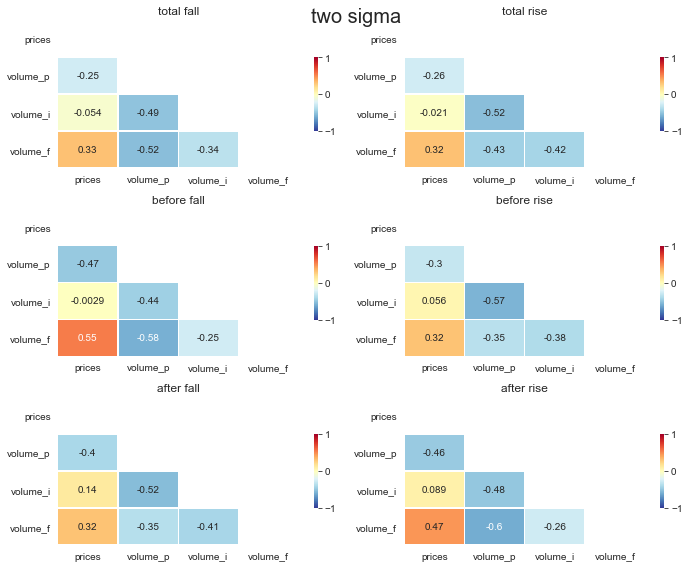

In [8]:
two_three = 2
corr_fall, corr_fall_n, corr_rise, corr_rise_n = get_corr(idx_list_all, two_three, m, n)
plot_corr(corr_fall, corr_rise, two_three)

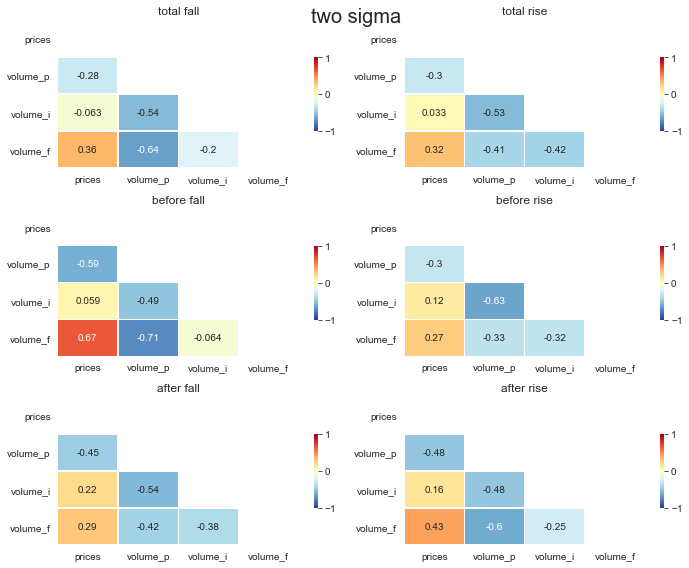

In [9]:
plot_corr(corr_fall_n, corr_rise_n, two_three)

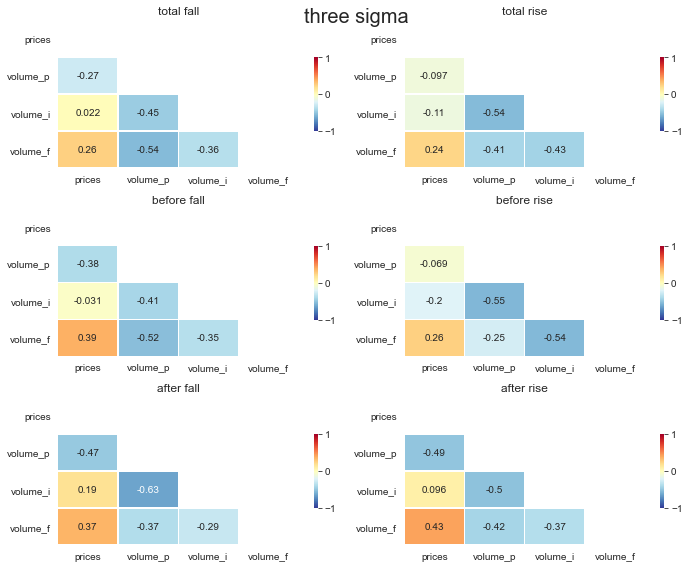

In [10]:
two_three = 3
corr_fall, corr_fall_n, corr_rise, corr_rise_n = get_corr(idx_list_all, two_three, m, n)
plot_corr(corr_fall, corr_rise, two_three)

In [11]:
# 주가 큰 변화가 있을 때 매매행태에 큰 변화가 있는 비율
# 주가 변화 이후 6일동안의 비율을 구한다.
def fall_rise(two_three):
    ratio_ff = []
    ratio_fr = []
    ratio_rr = []
    ratio_rf = []
    if two_three == 2:
        fall = twosigma_fall
        rise = twosigma_rise
    else:
        fall = threesigma_fall
        rise = threesigma_rise
    # 개인, 기관, 외국인 에 대해 주가 변동 이후 언제 매매 변동이 일어나는지 비율 구한다.
    for i in range(1,4):
        for d in range(6):
            t_ff = list((fall[0].index+d) & fall[i].index)
            ratio_ff.append(len(t_ff)/len(fall[0]))
            t_fr = list((fall[0].index+d) & rise[i].index)
            ratio_fr.append(len(t_fr)/len(fall[0]))
            t_rf = list((rise[0].index+d) & fall[i].index)
            ratio_rf.append(len(t_rf)/len(rise[0]))
            t_rr = list((rise[0].index+d) & rise[i].index)
            ratio_rr.append(len(t_rr)/len(rise[0]))
    vp_ratio = np.array([ratio_ff[:6], ratio_fr[:6], ratio_rf[:6], ratio_rr[:6]])
    vi_ratio = np.array([ratio_ff[6:12], ratio_fr[6:12], ratio_rf[6:12], ratio_rr[6:12]])
    vf_ratio = np.array([ratio_ff[12:], ratio_fr[12:], ratio_rf[12:], ratio_rr[12:]])
    
    print("two sigma\n") if two_three == 2 else print("three sigma\n")
    l = ['fall fall', 'fall rise', 'rise fall', 'rise rise']
    for i in range(4):
        print(l[i])
        if len(vp_ratio[i][vp_ratio[i]>0.1]):
            print('private', np.round(vp_ratio[i][vp_ratio[i]>0.1] * 100, 2), list(np.where(vp_ratio[i]>0.1))[0])
        if len(vi_ratio[i][vi_ratio[i]>0.1]):
            print('institution', np.round(vi_ratio[i][vi_ratio[i]>0.1] * 100, 2), list(np.where(vi_ratio[i]>0.1))[0])
        if len(vf_ratio[i][vf_ratio[i]>0.1]):
            print('foreigner', np.round(vf_ratio[i][vf_ratio[i]>0.1] * 100, 2), list(np.where(vf_ratio[i]>0.1))[0])
        print()

In [12]:
# 개인 - 주가 rise일 때 단기간 크게 fall한다.
# 기관 - 주가 fall일 때 단기간 크게 rise한다.
# 외국인 - fall(rise)일 때 단기간 크게 fall(rise)한다.
######### 시각화? ############
fall_rise(2)

two sigma

fall fall
foreigner [15.91 10.39] [0 1]

fall rise
institution [13.31 11.36] [0 1]

rise fall
private [14.25] [0]

rise rise
foreigner [18.72] [0]



In [13]:
# 3sigma
fall_rise(3)

three sigma

fall fall
foreigner [17.39] [0]

fall rise
institution [10.14] [0]

rise fall
private [25.] [0]

rise rise
foreigner [22.22] [0]



### 투자 주체별 순매수의 하락세 혹은 상승세가 주가 변동성에 미치는 영향
<br>
개인투자자 비율의 하락(상승)은 주가 변동성 하락(상승)을 가져올 것이라는 가설에서 시작
<br>
추가로 기관, 외국인에 대한 행태도 확인

In [14]:
# 투자 주체 순매수 -> 주가
# 60일 평균 개인 순매수가 60일 평균 코스피지수/-2(2) 보다 낮(높)은 경우
# 60일 평균보다 30일 평균이 낮(높)은 경우 (최근에 순매수 하락(상승)폭이 커야함)
d = 5  # 날짜간 앞 뒤 간격
ratio = 3  # 코스피 기준 어느정도 하락(상승) 해야하는지에 대한 기준

def change_per_subject(sub):
    if sub == 'p':
        col = 'volume_p' 
    elif sub == 'i':
        col = 'volume_i'
    else:
        col = 'volume_f'
    
    # 뒤에서 -90할 때 음수 idx 나오는것 방지
    mean_30 = df[30:][col].rolling(30).mean().dropna()
    mean_60 = df[30:][col].rolling(60).mean().dropna()
    price_mean_60 = df.prices.rolling(60).mean().dropna()
    fall_60 = mean_60[mean_60 < price_mean_60[mean_60.index]/ratio*-1].sort_values()
    rise_60 = mean_60[mean_60 > price_mean_60[mean_60.index]/ratio].sort_values()

    fall = np.ones(len(mean_60)) * -100
    rise = np.ones(len(mean_60)) * -100
    idx_f = 0
    idx_r = 0
    for f,r in zip(fall_60.index, rise_60.index):
        if mean_30[f] < mean_60[f]:
            if not (set(fall[fall > f - d]) & set(fall[fall < f + d])):
                fall[idx_f] = f
                idx_f += 1
        if mean_30[r] > mean_60[r]:
            if not (set(rise[rise > r - d]) & set(rise[rise < r + d])):
                rise[idx_r] = r
                idx_r += 1
    fall = fall[:idx_f].astype(int)
    rise = rise[:idx_r].astype(int)
    
    return [fall, rise]

In [15]:
# idx-90 ~ idx-60 을 투자 주체 감소(증가)전, 기준 주가 변동성으로 정한다.
# idx-30 ~ idx 을 투자 주체 감소(증가)의 확대에서 기준과 비교한다.
# idx-15 ~ idx+15 을 투자 주체 감소(증가)의 확대 이후로 해석하고 기준과 비교한다.
def print_ratio(idx_list, f_r, subj):
    num = np.array([0, 0])
    mean = np.array([0, 0])
    for i in idx_list:
        past = df.prices[i-90:i-60].std()
        present = df.prices[i-30:i].std()
        future = df.prices[i:i+30].std()
        if f_r == 'fall':
            if past > present:
                num[0] += 1
            if past > future:
                num[1] += 1
        else:
            if past < present:
                num[0] += 1
            if past < future:
                num[1] += 1
        mean[0] += present - past
        mean[1] += future - past
    mean = mean / len(idx_list)
    
    fig, axes = plt.subplots(1,2)
    axes[0].pie([num[0], len(idx_list) - num[0]], labels = ['fall', 'rise'], autopct = '%0.2f%%', startangle = 90)
    axes[1].pie([num[1], len(idx_list) - num[1]], labels = ['fall', 'rise'], autopct = '%0.2f', startangle = 90)
    plt.suptitle(f'{subj} {f_r} then price', fontsize=15)
    axes[0].set_title('present')
    axes[1].set_title('future')
    print(f'how much (mean) : {round(mean[0], 2), round(mean[1], 2)}')

how much (mean) : (-15.68, -29.68)
how much (mean) : (13.84, 3.59)


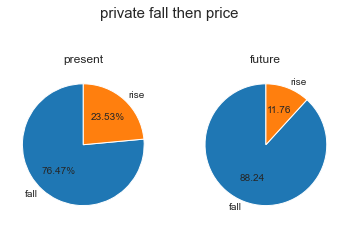

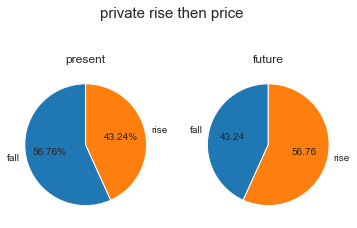

In [16]:
# 개인 투자자의 순매수 변화에 따른 주가 변동성 변화
fall, rise = change_per_subject('p')
print_ratio(fall, 'fall', 'private')
print_ratio(rise, 'rise', 'private')

institiution

how much (mean) : (1.37, 2.93)
how much (mean) : (10.71, 2.03)


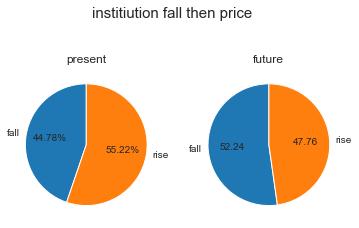

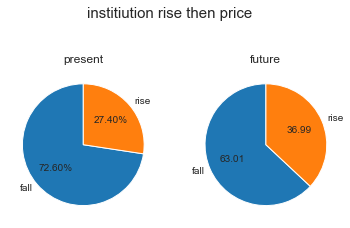

In [17]:
# 기관
fall, rise = change_per_subject('i')
print('institiution\n')
print_ratio(fall, 'fall', 'institiution')
print_ratio(rise, 'rise', 'institiution')

Foreigner

how much (mean) : (23.42, 3.44)
how much (mean) : (-0.9, -5.53)


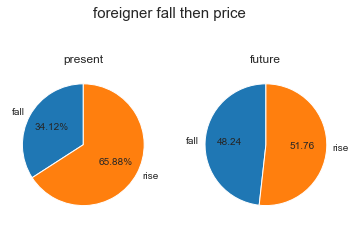

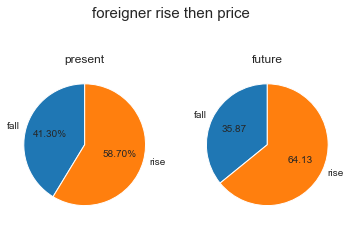

In [18]:
# 외국인
fall, rise = change_per_subject('f')
print('Foreigner\n')
print_ratio(fall, 'fall', 'foreigner')
print_ratio(rise, 'rise', 'foreigner')